Check if dataset exists

# 🎬 Netflix Content Intelligence on Databricks Free Edition

This notebook explores the **Netflix Movies & TV Shows** dataset using **Databricks Free Edition**.

We will:
- Ingest and inspect the dataset
- Clean and standardize release dates
- Engineer features such as release decade and content age
- Run SQL-based exploratory data analysis
- Visualize trends and distributions
- Build a simple natural language query interface for analytics


#### Load & Inspect table

In [0]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.recommendation import ALS
from matplotlib import pyplot as plt
import seaborn as sns

# 1. Load table as Spark DataFrame
df = spark.table("workspace.default.netflix_dataset")
print(f"Dataset loaded successfully! Total rows: {df.count():,}")

# inspect your dataset

print("=" * 70)
print("DATASET INSPECTION")
print("=" * 70)

print("\n Schema:")
df.printSchema()

print("\n Sample rows:")
display(df.limit(5))

print("\n Columns:", df.columns)

# Show record count
print(f"\n Total Records: {df.count():,}")

# Show sample data
print("\n🔍 Sample Data:")
display(df.limit(5))

# Check for null values
print("\n⚠️  Null Value Count by Column:")
null_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
display(null_counts)

Dataset loaded successfully! Total rows: 7,791
DATASET INSPECTION

 Schema:
root
 |-- Show_Id: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Director: string (nullable = true)
 |-- Cast: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Release_Date: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Duration: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Description: string (nullable = true)


 Sample rows:


Show_Id,Category,Title,Director,Cast,Country,Release_Date,Rating,Duration,Type,Description
s1,TV Show,3%,null,"João Miguel, Bianca Comparato, Michel Gomes, Rodolfo Valente, Vaneza Oliveira, Rafael Lozano, Viviane Porto, Mel Fronckowiak, Sergio Mamberti, Zezé Motta, Celso Frateschi",Brazil,"August 14, 2020",TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi & Fantasy","In a future where the elite inhabit an island paradise far from the crowded slums, you get one chance to join the 3% saved from squalor."
s2,Movie,07:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, Azalia Ortiz, Octavio Michel, Carmen Beato",Mexico,"December 23, 2016",TV-MA,93 min,"Dramas, International Movies","After a devastating earthquake hits Mexico City, trapped survivors from all walks of life wait to be rescued while trying desperately to stay alive."
s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence Koh, Tommy Kuan, Josh Lai, Mark Lee, Susan Leong, Benjamin Lim",Singapore,"December 20, 2018",R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow soldiers are forced to confront a terrifying secret that's haunting their jungle island training camp."
s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly, Christopher Plummer, Crispin Glover, Martin Landau, Fred Tatasciore, Alan Oppenheimer, Tom Kane",United States,"November 16, 2017",PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi & Fantasy","In a postapocalyptic world, rag-doll robots hide in fear from dangerous machines out to exterminate them, until a brave newcomer joins the group."
s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aaron Yoo, Liza Lapira, Jacob Pitts, Laurence Fishburne, Jack McGee, Josh Gad, Sam Golzari, Helen Carey, Jack Gilpin",United States,"January 1, 2020",PG-13,123 min,Dramas,A brilliant group of students become card-counting experts with the intent of swindling millions out of Las Vegas casinos by playing blackjack.



 Columns: ['Show_Id', 'Category', 'Title', 'Director', 'Cast', 'Country', 'Release_Date', 'Rating', 'Duration', 'Type', 'Description']

 Total Records: 7,791

🔍 Sample Data:


Show_Id,Category,Title,Director,Cast,Country,Release_Date,Rating,Duration,Type,Description
s1,TV Show,3%,null,"João Miguel, Bianca Comparato, Michel Gomes, Rodolfo Valente, Vaneza Oliveira, Rafael Lozano, Viviane Porto, Mel Fronckowiak, Sergio Mamberti, Zezé Motta, Celso Frateschi",Brazil,"August 14, 2020",TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi & Fantasy","In a future where the elite inhabit an island paradise far from the crowded slums, you get one chance to join the 3% saved from squalor."
s2,Movie,07:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, Azalia Ortiz, Octavio Michel, Carmen Beato",Mexico,"December 23, 2016",TV-MA,93 min,"Dramas, International Movies","After a devastating earthquake hits Mexico City, trapped survivors from all walks of life wait to be rescued while trying desperately to stay alive."
s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence Koh, Tommy Kuan, Josh Lai, Mark Lee, Susan Leong, Benjamin Lim",Singapore,"December 20, 2018",R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow soldiers are forced to confront a terrifying secret that's haunting their jungle island training camp."
s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly, Christopher Plummer, Crispin Glover, Martin Landau, Fred Tatasciore, Alan Oppenheimer, Tom Kane",United States,"November 16, 2017",PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi & Fantasy","In a postapocalyptic world, rag-doll robots hide in fear from dangerous machines out to exterminate them, until a brave newcomer joins the group."
s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aaron Yoo, Liza Lapira, Jacob Pitts, Laurence Fishburne, Jack McGee, Josh Gad, Sam Golzari, Helen Carey, Jack Gilpin",United States,"January 1, 2020",PG-13,123 min,Dramas,A brilliant group of students become card-counting experts with the intent of swindling millions out of Las Vegas casinos by playing blackjack.



⚠️  Null Value Count by Column:


Show_Id,Category,Title,Director,Cast,Country,Release_Date,Rating,Duration,Type,Description
0,1,2,2390,719,509,12,9,2,3,3


####Clean Release_Date and extract release_year

In [0]:
from pyspark.sql.functions import (
    col, floor, year, current_date, when, to_date, regexp_replace, coalesce, lit
)

# Data cleaning - drop rows with missing critical fields
df_clean = df.na.drop(subset=["Title", "Type"])

# remove leading/trailing unicode spaces
df = df_clean.withColumn(
    "Release_Date_clean",
    regexp_replace(col("Release_Date"), r"^[\s\u00A0\u200B]+", "")
)

df = df.withColumn("Release_Date_clean", trim(col("Release_Date_clean")))

# Try multiple date formats
df = df.withColumn(
    "release_date_parsed",
    when(
        to_date(col("Release_Date_clean"), "MMMM d, yyyy").isNotNull(),
        to_date(col("Release_Date_clean"), "MMMM d, yyyy")
    )
    .when(
        to_date(col("Release_Date_clean"), "MMMM yyyy").isNotNull(),
        to_date(col("Release_Date_clean"), "MMMM yyyy")
    )
    .when(
        to_date(col("Release_Date_clean"), "yyyy").isNotNull(),
        to_date(col("Release_Date_clean"), "yyyy")
    )
)

# Extract release_year

df = df.withColumn("release_year", year(col("release_date_parsed")))



####Extract release_year reliably

In [0]:
df = df.withColumn("release_year", year(col("release_date_parsed")))

In [0]:
df = df.withColumn(
    "release_year",
    when(col("release_year").isNull(),
         regexp_replace(col("release_date_parsed"), r"[^0-9]", "").cast("int"))
    .otherwise(col("release_year"))
)
df

DataFrame[Show_Id: string, Category: string, Title: string, Director: string, Cast: string, Country: string, Release_Date: string, Rating: string, Duration: string, Type: string, Description: string, Release_Date_clean: string, release_date_parsed: date, release_year: int]

In [0]:
df.columns

['Show_Id',
 'Category',
 'Title',
 'Director',
 'Cast',
 'Country',
 'Release_Date',
 'Rating',
 'Duration',
 'Type',
 'Description',
 'Release_Date_clean',
 'release_date_parsed',
 'release_year']

In [0]:
from pyspark.sql.functions import col, year, regexp_extract

df = df.withColumn(
    "release_year",
    year(col("release_date_parsed"))
)

# fallback: extract 4-digit year if year() returned null
df = df.withColumn(
    "release_year",
    when(
        col("release_year").isNull(),
        regexp_extract(col("Release_Date_clean"), r"(\d{4})", 1).cast("int")
    ).otherwise(col("release_year"))
)

In [0]:
df_clean = df_clean.na.drop(subset=["release_year"])

####Feature engineering → df_processed

In [0]:
from pyspark.sql.functions import floor, current_date, year, when

df_processed = (
    df
    .withColumn("release_decade", (floor(col("release_year") / 10) * 10).cast("int"))
    .withColumn("content_age_years", year(current_date()) - col("release_year"))
    .withColumn("is_recent", when(col("release_year") >= 2020, 1).otherwise(0))
)

df_processed.createOrReplaceTempView("netflix_content")

#### Exploratory Data Analysis with SQL

In [0]:
%sql
Select * from `workspace`.`default`.`netflix_dataset` limit 5;

Show_Id,Category,Title,Director,Cast,Country,Release_Date,Rating,Duration,Type,Description
s1,TV Show,3%,null,"João Miguel, Bianca Comparato, Michel Gomes, Rodolfo Valente, Vaneza Oliveira, Rafael Lozano, Viviane Porto, Mel Fronckowiak, Sergio Mamberti, Zezé Motta, Celso Frateschi",Brazil,"August 14, 2020",TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi & Fantasy","In a future where the elite inhabit an island paradise far from the crowded slums, you get one chance to join the 3% saved from squalor."
s2,Movie,07:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, Azalia Ortiz, Octavio Michel, Carmen Beato",Mexico,"December 23, 2016",TV-MA,93 min,"Dramas, International Movies","After a devastating earthquake hits Mexico City, trapped survivors from all walks of life wait to be rescued while trying desperately to stay alive."
s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence Koh, Tommy Kuan, Josh Lai, Mark Lee, Susan Leong, Benjamin Lim",Singapore,"December 20, 2018",R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow soldiers are forced to confront a terrifying secret that's haunting their jungle island training camp."
s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly, Christopher Plummer, Crispin Glover, Martin Landau, Fred Tatasciore, Alan Oppenheimer, Tom Kane",United States,"November 16, 2017",PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi & Fantasy","In a postapocalyptic world, rag-doll robots hide in fear from dangerous machines out to exterminate them, until a brave newcomer joins the group."
s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aaron Yoo, Liza Lapira, Jacob Pitts, Laurence Fishburne, Jack McGee, Josh Gad, Sam Golzari, Helen Carey, Jack Gilpin",United States,"January 1, 2020",PG-13,123 min,Dramas,A brilliant group of students become card-counting experts with the intent of swindling millions out of Las Vegas casinos by playing blackjack.


#####Top Countries Producing Content

In [0]:
%sql
-- Top 10 countries producing content
SELECT 
    TRIM(country_single) AS Country,
    COUNT(*) AS count
FROM (
    SELECT EXPLODE(SPLIT(Country, ',')) AS country_single
    FROM workspace.default.netflix_dataset
    WHERE Country IS NOT NULL
)
GROUP BY TRIM(country_single)
ORDER BY count DESC
LIMIT 10;


Country,count
United States,2555
India,923
United Kingdom,397
Japan,226
South Korea,183
Canada,177
Spain,134
France,115
Egypt,101
Turkey,100


#####Distribution of Movies vs TV Shows

In [0]:
%sql
-- Content distribution by type
SELECT 
    Type,
    COUNT(*) as count,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER(), 2) as percentage
FROM `workspace`.`default`.`netflix_dataset`
GROUP BY Type
ORDER BY count DESC
limit 20;

Type,count,percentage
Documentaries,334,4.29
Stand-Up Comedy,321,4.12
"Dramas, International Movies",320,4.11
"Comedies, Dramas, International Movies",243,3.12
"Dramas, Independent Movies, International Movies",215,2.76
Kids' TV,205,2.63
Children & Family Movies,177,2.27
"Documentaries, International Movies",172,2.21
"Children & Family Movies, Comedies",169,2.17
"Comedies, International Movies",161,2.07


#####Content in each Category (Cleaned)

In [0]:
%sql
-- Top categories (genres)
SELECT 
    Category,
    COUNT(*) AS count
FROM `workspace`.`default`.`netflix_dataset`
WHERE Category IS NOT NULL
AND Category IN ('Movie','TV Show')
GROUP BY Category
ORDER BY count DESC
LIMIT 15;

Category,count
Movie,5379
TV Show,2410


#####Trends Over Time

In [0]:
%sql
-- Content trends over dates
SELECT 
    Release_Date,
    Type,
    COUNT(*) AS count
FROM `workspace`.`default`.`netflix_dataset`
where Release_Date is not null
GROUP BY Release_Date, Type
ORDER BY Release_Date, Type
limit 20;

Release_Date,Type,count
"April 15, 2018","Kids' TV, TV Comedies",1
"April 16, 2019","Kids' TV, TV Comedies",1
"April 17, 2016","TV Dramas, TV Horror, TV Mysteries",1
"April 20, 2017","International TV Shows, Korean TV Shows, TV Comedies",1
"April 4, 2017","British TV Shows, International TV Shows, Romantic TV Shows",1
"August 1, 2017","Kids' TV, Korean TV Shows",1
"August 13, 2018",Kids' TV,1
"August 21, 2017","Crime TV Shows, International TV Shows, TV Dramas",1
"August 4, 2017",Docuseries,1
"August 4, 2017","International TV Shows, Korean TV Shows, Reality TV",1


####Advanced Analytics and visualization

In [0]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler, StringIndexer
from matplotlib import pyplot as plt
import seaborn as sns

In [0]:
from pyspark.sql.functions import lower, when, col

df_types = df_processed.withColumn(
    "Type_Clean",
    when(lower(col("Type")).like("%movie%"), "Movie")
    .when(lower(col("Type")).like("%show%"), "TV Show")
    .otherwise("Other")
)

In [0]:
df_plot = df_types.filter(col("Type_Clean").isin("Movie", "TV Show"))
pdf = df_plot.select("release_decade", "Type_Clean").toPandas()

<Figure size 1200x600 with 0 Axes>

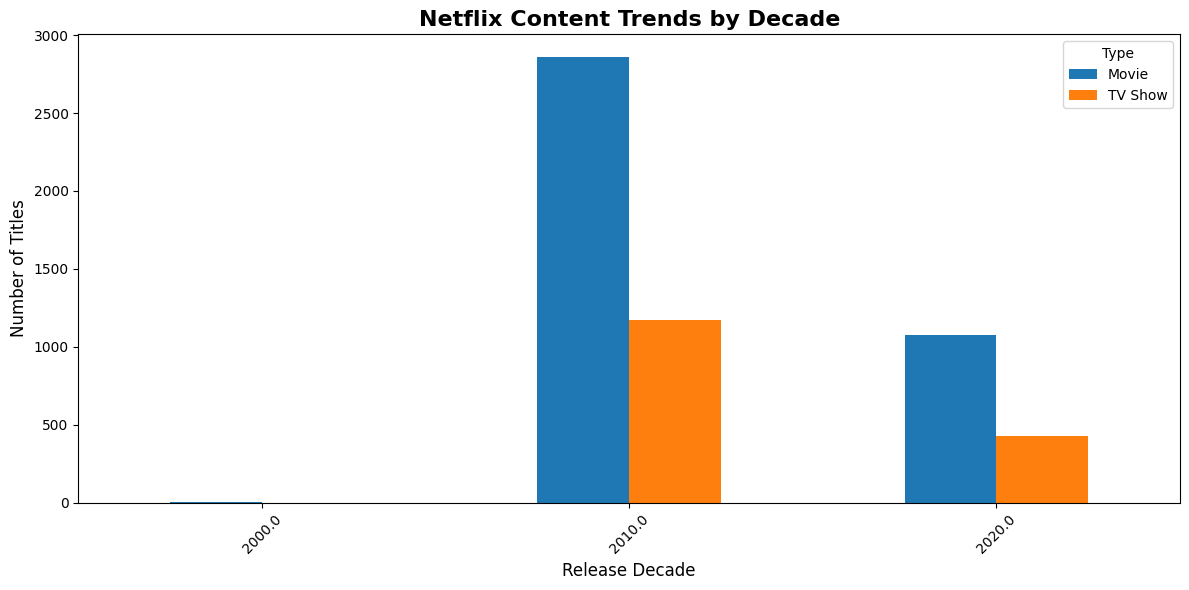

In [0]:
# Visualization 1 (Improved): Content trends by decade
plt.figure(figsize=(12, 6))
decade_counts = pdf.groupby(['release_decade', 'Type_Clean']).size().unstack(fill_value=0)


decade_counts.plot(kind='bar', figsize=(12, 6))
plt.title('Netflix Content Trends by Decade', fontsize=16, fontweight='bold')
plt.xlabel('Release Decade', fontsize=12)
plt.ylabel('Number of Titles', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Type')
plt.tight_layout()
plt.show()

In [0]:
from pyspark.sql.functions import col, trim

df_type_clean = df_processed.withColumn(
    "Type_Clean",
    trim(col("Type"))
)

In [0]:
from pyspark.sql.functions import row_number
from pyspark.sql.window import Window

# Count per year per type
year_type_counts = (
    df_type_clean
    .groupBy("release_year", "Type_Clean")
    .count()
)

# Rank within each year
window = Window.partitionBy("release_year").orderBy(col("count").desc())

ranked = year_type_counts.withColumn(
    "rank", row_number().over(window)
)

In [0]:
top5_all_years = (
    ranked.filter(col("rank") <= 5)
    .select("Type_Clean")
    .distinct()
)

top5_list = [row["Type_Clean"] for row in top5_all_years.collect()]
top5_list

['Classic & Cult TV, TV Comedies',
 'Anime Series, Crime TV Shows',
 'British TV Shows, TV Comedies, TV Dramas',
 'Docuseries',
 "Kids' TV",
 'Stand-Up Comedy & Talk Shows',
 'Dramas, Independent Movies, Thrillers',
 'Dramas, International Movies',
 'Horror Movies',
 'Cult Movies, Horror Movies',
 'Dramas',
 'Dramas, Sports Movies',
 'Children & Family Movies, Dramas, Faith & Spirituality',
 'Dramas, Thrillers',
 'Documentaries',
 'Comedies',
 'Children & Family Movies, Comedies',
 'Stand-Up Comedy',
 'Crime TV Shows, TV Dramas, TV Thrillers',
 'Crime TV Shows, International TV Shows, TV Dramas',
 'TV Dramas, Teen TV Shows',
 'Docuseries, Stand-Up Comedy & Talk Shows',
 'Movies',
 'Documentaries, International Movies',
 'Children & Family Movies',
 "Kids' TV, TV Comedies",
 'International TV Shows, Romantic TV Shows, TV Comedies',
 'Dramas, Independent Movies, International Movies',
 'Comedies, Dramas, International Movies',
 'Action & Adventure']

In [0]:
df_filtered = df_type_clean.filter(col("Type_Clean").isin(top5_list))
pdf = df_filtered.select("release_year", "Type_Clean").toPandas()
trend = pdf.groupby(['release_year', 'Type_Clean']).size().unstack(fill_value=0)

# Optional smoothing
trend_smoothed = trend.rolling(window=2, center=True).mean()

<Figure size 1600x800 with 0 Axes>

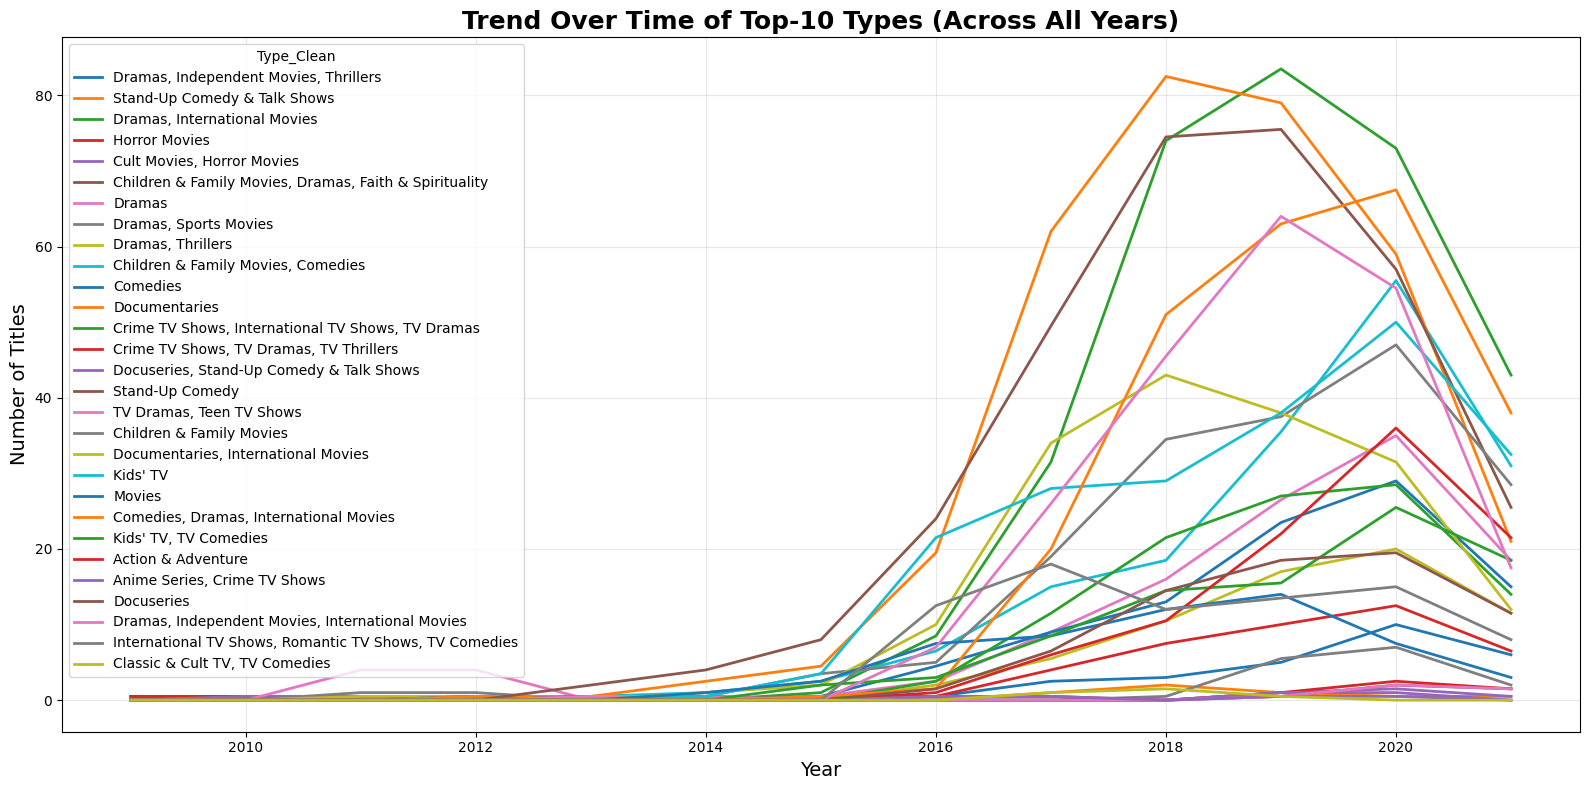

In [0]:
plt.figure(figsize=(16, 8))

trend_smoothed.plot(linewidth=2, figsize=(16, 8))
plt.title("Trend Over Time of Top Types (Across All Years)", fontsize=18, fontweight='bold')
plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of Titles", fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

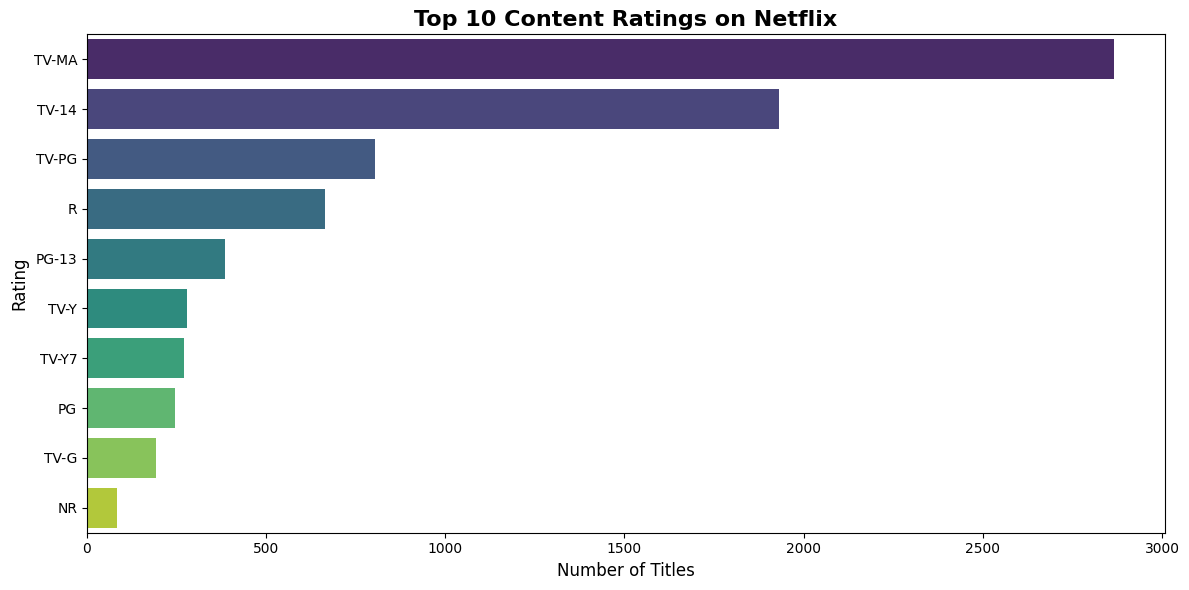

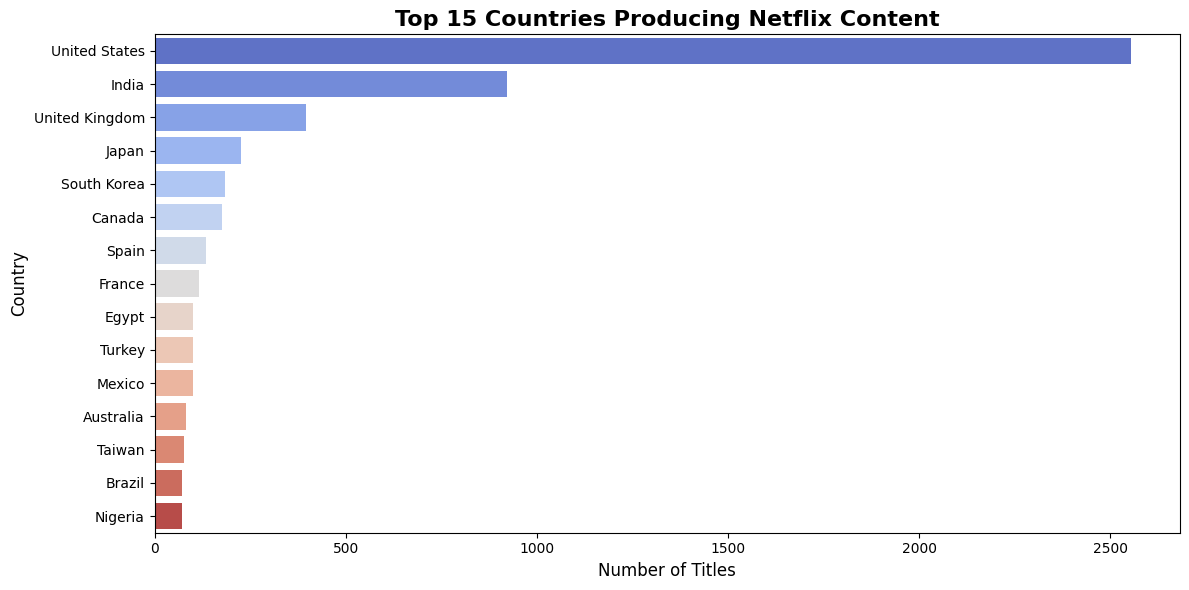

In [0]:

# Convert to Pandas for visualization

pdf = df_processed.select(
    "Type", "release_year", "release_decade", "Rating", "Country"
).toPandas()

# Visualization 3: Top ratings distribution
plt.figure(figsize=(12, 6))
rating_counts = pdf['Rating'].value_counts().head(10)
sns.barplot(x=rating_counts.values, y=rating_counts.index, palette='viridis')
plt.title('Top 10 Content Ratings on Netflix', fontsize=16, fontweight='bold')
plt.xlabel('Number of Titles', fontsize=12)
plt.ylabel('Rating', fontsize=12)
plt.tight_layout()
plt.show()

# Visualization 4: Top countries
plt.figure(figsize=(12, 6))
top_countries = pdf['Country'].value_counts().head(15)
sns.barplot(x=top_countries.values, y=top_countries.index, palette='coolwarm')
plt.title('Top 15 Countries Producing Netflix Content', fontsize=16, fontweight='bold')
plt.xlabel('Number of Titles', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.tight_layout()
plt.show()

In [0]:
df_types

DataFrame[Show_Id: string, Category: string, Title: string, Director: string, Cast: string, Country: string, Release_Date: string, Rating: string, Duration: string, Type: string, Description: string, Release_Date_clean: string, release_date_parsed: date, release_year: int, release_decade: int, content_age_years: int, is_recent: int, Type_Clean: string]

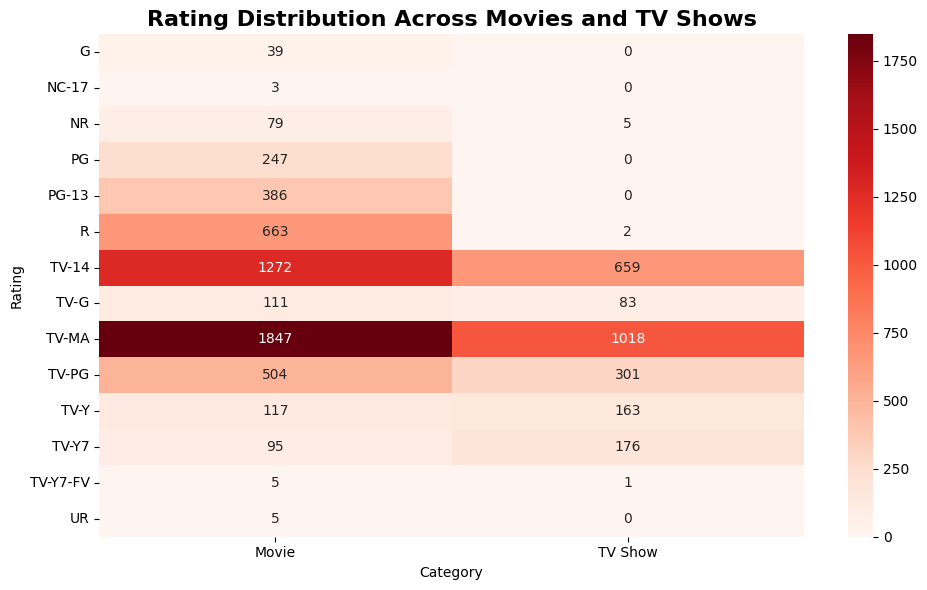

In [0]:
plt.figure(figsize=(10, 6))
tdf = df_types.select(
    "Type", "release_year", "release_decade", "Rating", "Country", "Category"
).toPandas()
df_types
rating_type = tdf.pivot_table(index='Rating', columns='Category', aggfunc='size', fill_value=0)

sns.heatmap(rating_type, cmap='Reds', annot=True, fmt='d')
plt.title('Rating Distribution Across Movies and TV Shows', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

#### Executive Summary

In [0]:
summary = df_processed.agg(
    {"release_year": "min", "title": "count"}
).collect()[0]

print("Summary:")
print(f"Total Titles: {df_processed.count():,}")
print(f"Earliest Release Year: {summary['min(release_year)']}")

Summary:
Total Titles: 7,788
Earliest Release Year: 2008


### Recommendations

In [0]:
df.columns

['Show_Id',
 'Category',
 'Title',
 'Director',
 'Cast',
 'Country',
 'Release_Date',
 'Rating',
 'Duration',
 'Type',
 'Description',
 'Release_Date_clean',
 'release_date_parsed',
 'release_year']

In [0]:
%python
rows = df_processed.select(
    "Title", 
    "Description", 
    "Category",
    "Country",
    "Type",
    "release_year",
    "Rating"
).collect()

rows[:3]

[Row(Title='3%', Description='In a future where the elite inhabit an island paradise far from the crowded slums, you get one chance to join the 3% saved from squalor.', Category='TV Show', Country='Brazil', Type='International TV Shows, TV Dramas, TV Sci-Fi & Fantasy', release_year=2020, Rating='TV-MA'),
 Row(Title='07:19', Description='After a devastating earthquake hits Mexico City, trapped survivors from all walks of life wait to be rescued while trying desperately to stay alive.', Category='Movie', Country='Mexico', Type='Dramas, International Movies', release_year=2016, Rating='TV-MA'),
 Row(Title='23:59', Description="When an army recruit is found dead, his fellow soldiers are forced to confront a terrifying secret that's haunting their jungle island training camp.", Category='Movie', Country='Singapore', Type='Horror Movies, International Movies', release_year=2018, Rating='R')]

In [0]:
%python
import pandas as pd

pdf = pd.DataFrame([r.asDict() for r in rows])
pdf = pdf.fillna("")

In [0]:
type(pdf)

pandas.core.frame.DataFrame

In [0]:
%python
text_cols = ["Title", "Description", "Category", "Country"]
pdf["text_features"] = pdf[text_cols].agg(" ".join, axis=1)


In [0]:
%python
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
tfidf = vectorizer.fit_transform(pdf["text_features"])
cosine_sim = cosine_similarity(tfidf)

In [0]:
%python
import multiprocessing as mp
import pandas as pd

def recommend_subprocess(title, top_n, pdf, cosine_sim):
    import builtins  # <-- makes sure we use REAL round()

    if title not in pdf["Title"].values:
        return []

    idx = pdf.index[pdf["Title"] == title][0]

    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]

    results = []
    for i, score in sim_scores:
        results.append({
            "Title": pdf.iloc[i]["Title"],
            "Type": pdf.iloc[i]["Type"],
            "Release Year": int(float(pdf.iloc[i]["release_year"])),
            "Rating": pdf.iloc[i]["Rating"],
            "Similarity": builtins.round(float(score), 3)   # <-- FIXED
        })

    return results

def recommend(title, top_n=5):
    import multiprocessing as mp
    import pandas as pd

    with mp.Pool(1) as pool:
        out = pool.apply(
            recommend_subprocess,
            args=(title, top_n, pdf, cosine_sim)
        )
    return pd.DataFrame(out)

In [0]:
pdf["Title"].sample(10)

283                   Abhinetri
2396     Ghost of the Mountains
3160          Jewel's Catch One
94                      28 Days
3744                 Love Alarm
1387    CIA: Comrade in America
4013            Meditation Park
6144          The Bleeding Edge
3760         Love Is in the Air
1571              Daagdi Chaawl
Name: Title, dtype: object

In [0]:
recommend("3%", 10)

,Title,Type,Release Year,Rating,Similarity
0,Fire in Paradise,Documentaries,2019,TV-MA,0.201
1,Stoked,Kids' TV,2017,TV-PG,0.198
2,Mosul,"Action & Adventure, Dramas, International Movies",2020,TV-MA,0.180
3,High Society,"Dramas, International Movies",2019,TV-MA,0.177
4,Dating Around: Brazil,"International TV Shows, Reality TV, Romantic T...",2020,TV-14,0.169
5,Teresa,"International TV Shows, Romantic TV Shows, Spa...",2017,TV-PG,0.167
6,"My Schoolmate, the Barbarian","Action & Adventure, Comedies, International Mo...",2018,TV-14,0.163
7,The Stranded,"International TV Shows, TV Action & Adventure,...",2019,TV-MA,0.159
8,Paradise Lost,"Dramas, Independent Movies, International Movies",2018,TV-MA,0.159
9,Expelled from Paradise,"Action & Adventure, Anime Features, Sci-Fi & F...",2018,TV-MA,0.151
